##
**Title:** Contextual Embeddings as Dynamic Mixtures in BERT

**Abstract:**  
This project investigates how contextual meaning is computed in transformer language models. Using the ambiguous token “rose,” I compare its embeddings across BERT layers in flower and verb contexts. Embeddings remain similar in early layers but diverge in deeper layers, consistent with increasing contextualization. To quantify contextual variation, we compared embeddings using cosine similarity, which measures directional alignment in high-dimensional space. We observed that tokens sharing semantic roles tend to have higher similarity than tokens sharing only surface form, supporting our hypothesis that BERT encodes meaning dynamically rather than storing a single representation per word type.




### BERT contextual embeddings
For an input token sequence $x_{1:T}$, BERT produces layer-wise hidden states:
$$
H^{(\ell)} = [h_1^{(\ell)}, h_2^{(\ell)}, \dots, h_T^{(\ell)}] \in \mathbb{R}^{T \times d},
\quad \ell=0,1,\dots,L
$$
where $h_t^{(\ell)}$ is the contextual embedding of token $t$ at layer $\ell$.

### Similarity
Given two embeddings $u, v \in \mathbb{R}^d$, cosine similarity is
$$
\cos(u,v) = \frac{u^\top v}{\|u\|\|v\|}.
$$
We will track $\cos(h_{t_A}^{(\ell)}, h_{t_B}^{(\ell)})$ across layers $\ell$ for the token “rose” in different contexts.

### Attention (one head)
In scaled dot-product attention (for a head):
$$
\mathrm{Attn}(Q,K,V) = \mathrm{softargmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right)V.
$$
The softargmax matrix provides attention weights $A$ that tell us how much each token attends to others.


## 0) Setup

We will:
- use a pretrained BERT model from Hugging face,
- extract hidden states for all layers,
- extract attention weights,
- run small controlled experiments,
- visualize results.




In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


## 1) Load BERT

We use BERT as a frozen feature extractor.

We need:
- hidden states (all 12 layers),
- attentions (all 12 layers),
so we enable `output_hidden_states=True` and `output_attentions=True` in the forward pass.


In [ ]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

## 2) Helper functions

We implement small, transparent utilities:
1. cosine similarity
2. run BERT and extract hidden states + attentions
3. locate “rose” token index safely
4. compute layer-wise similarity trajectory



### 2.1 Cosine similarity
$$
\cos(u,v)=\frac{u^\top v}{\|u\|\|v\|}
$$


In [ ]:
def cosine_similarity(u, v, eps=1e-12):
    u, v = np.array(u), np.array(v)
    dot = np.dot(u, v)
    norm = np.linalg.norm(u) * np.linalg.norm(v)
    return dot / (norm + eps)

### 2.2 Run BERT and extract hidden states + attentions

Returns:
- tokens: list of token strings
- hidden_states_np: list of arrays (T, d) for layers 0..L
- attentions_np: list of arrays (H, T, T) for layers 1..L


In [ ]:
@torch.no_grad()
def run_bert(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=True).to(device)
    outputs = model(**inputs, output_hidden_states=True, output_attentions=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist())
    hidden_states = [h[0].cpu().numpy() for h in outputs.hidden_states]
    attentions = [a[0].cpu().numpy() for a in outputs.attentions]

    return tokens, hidden_states, attentions


In [ ]:
# example code
t, h, a = run_bert("I gave my mom a rose.")
print(t)
print(len(h))
print(len(h[1]))
print(len(h[1][0]))
print(len(a[1]))

['[CLS]', 'i', 'gave', 'my', 'mom', 'a', 'rose', '.', '[SEP]']
13
9
768
12


### 2.3 Find the token index for "rose" (WordPiece-safe)

BERT tokenizes into WordPieces. We search for token == "rose".


In [ ]:
def find_token_index(tokens, target_token="rose", occurrence=0):
    """Find the index of the target token in the list."""
    indices = [i for i, t in enumerate(tokens) if t == target_token]
    if not indices or occurrence >= len(indices):
        raise ValueError(f"Token '{target_token}' (occ {occurrence}) not found in {tokens}")
    return indices[occurrence]

### 2.4 Layer trajectory of “rose” similarity

$$
s^{(\ell)} = \cos(r_A^{(\ell)}, r_B^{(\ell)}).
$$


In [ ]:
def rose_similarity_trajectory(sentence_a, sentence_b, target_token="rose"):
    tok_a, hs_a, att_a = run_bert(sentence_a)
    tok_b, hs_b, att_b = run_bert(sentence_b)

    idx_a = find_token_index(tok_a, target_token)
    idx_b = find_token_index(tok_b, target_token)

    sims = [
        cosine_similarity(hs_a[layer][idx_a], hs_b[layer][idx_b])
        for layer in range(len(hs_a))
    ]

    return {
        "tokens_a": tok_a, "tokens_b": tok_b,
        "idx_a": idx_a, "idx_b": idx_b,
        "hs_a": hs_a, "hs_b": hs_b,
        "att_a": att_a, "att_b": att_b,
        "sims": np.array(sims),
        "sentence_a": sentence_a, "sentence_b": sentence_b
    }

### 2.5 Extract layer-wise embeddings for a specific token from a sentence

In [ ]:
def extract_layerwise_embeddings(sentence, target_token="rose", occurrence=0):
    tokens, hidden_states, _ = run_bert(sentence)
    token_idx = find_token_index(tokens, target_token, occurrence)

    layerwise_embeddings = [
        hs[token_idx] for hs in hidden_states
    ]
    return layerwise_embeddings

## Verb-vs-Flower Analysis

### Hypothesis
BERT embeddings for the ambiguous token 'rose' will dynamically diverge across layers when presented in sentences emphasizing different senses (flower vs. verb). Specifically, within-sense similarities (flower-flower or verb-verb) will remain high or increase, while between-sense similarities (flower-verb) will decrease in deeper layers, indicating contextual disambiguation.

### Predictions
- **Prediction 1 (Flower-Flower Similarity):** Cosine similarity between 'rose' embeddings from two flower-context sentences will remain high and stable, or even slightly increase, across layers.
- **Prediction 2 (Verb-Verb Similarity):** Cosine similarity between 'rose' embeddings from two verb-context sentences will remain high and stable, or even slightly increase, across layers.
- **Prediction 3 (Flower-Verb Similarity):** Cosine similarity between 'rose' embeddings from a flower-context sentence and a verb-context sentence will start relatively high in early layers and decrease significantly in deeper layers.

### Rationale for Sentence Design
To rigorously test this hypothesis, we have meticulously crafted pairs of sentences that clearly disambiguate the 'rose' token into either its noun (flower) or verb sense. Each sentence is designed to provide sufficient context to bias BERT towards one specific meaning. This controlled experimental setup allows us to observe and quantify the layer-wise evolution of semantic distinction within BERT.

In [ ]:

pairs = [
    ("I gave my mom a rose.", "The sun rose at dawn."),
    ("She smelled the rose in the garden.", "The balloon rose into the sky."),
    ("He watered the rose every morning.", "Prices rose after the announcement."),
    ("The rose was red and beautiful.", "The temperature rose quickly today."),
]

focus_a = "I gave my mom a rose."
focus_b = "The sun rose at dawn."

flower_sentences = [
    "I gave my mom a rose.",
    "She smelled the rose in the garden.",
    "He watered the rose every morning.",
    "The rose was red and beautiful."
]

verb_sentences = [
    "The sun rose at dawn.",
    "The balloon rose into the sky.",
    "Prices rose after the announcement.",
    "The temperature rose quickly today."
]

all_sentences = flower_sentences + verb_sentences

sense_labels = ["flower"] * len(flower_sentences) + ["verb"] * len(verb_sentences)

## 3) Experiments

## Extract All Layer-wise Embeddings

Extract layer-wise embeddings for the 'rose' token from each sentence in `all_sentences` and store them in a single tensor `E` (N, L, D).


In [ ]:
all_embeddings_list = []

for sentence in all_sentences:
    layerwise_embs = extract_layerwise_embeddings(sentence, target_token="rose")
    all_embeddings_list.append(layerwise_embs)
E = np.array(all_embeddings_list)

print(f"Shape of E (num_sentences, num_layers, embedding_dim): {E.shape}")

Shape of E (num_sentences, num_layers, embedding_dim): (8, 13, 768)


In [ ]:
num_sentences = E.shape[0]
num_layers = E.shape[1]

layerwise_similarities = np.zeros((num_layers, num_sentences, num_sentences))

for layer in range(num_layers):
    for i in range(num_sentences):
        for j in range(num_sentences):
            # E[i, layer] gives the 'rose' embedding for sentence i at the current layer
            # E[j, layer] gives the 'rose' embedding for sentence j at the current layer
            layerwise_similarities[layer, i, j] = cosine_similarity(E[i, layer], E[j, layer])

print(f"Shape of layerwise_similarities (num_layers, num_sentences, num_sentences): {layerwise_similarities.shape}")

Shape of layerwise_similarities (num_layers, num_sentences, num_sentences): (13, 8, 8)


13
[np.float64(0.9999999403953552), np.float64(0.9436264038085938), np.float64(0.9367875456809998), np.float64(0.913366436958313), np.float64(0.8796153664588928), np.float64(0.8755578398704529), np.float64(0.8679148554801941), np.float64(0.8745386600494385), np.float64(0.8679523468017578), np.float64(0.8473520874977112), np.float64(0.8763180375099182), np.float64(0.8911632895469666), np.float64(0.8492608666419983)]
[np.float64(0.9477969606717428), np.float64(0.889200359582901), np.float64(0.8650131821632385), np.float64(0.8547701438268026), np.float64(0.81849338610967), np.float64(0.808482696612676), np.float64(0.8084086775779724), np.float64(0.8186711569627126), np.float64(0.8186538815498352), np.float64(0.7923918465773264), np.float64(0.7923021912574768), np.float64(0.8128273189067841), np.float64(0.7755683859189352)]
[np.float64(0.9191333651542664), np.float64(0.8586811423301697), np.float64(0.8087807893753052), np.float64(0.8232534527778625), np.float64(0.7736331224441528), np.floa

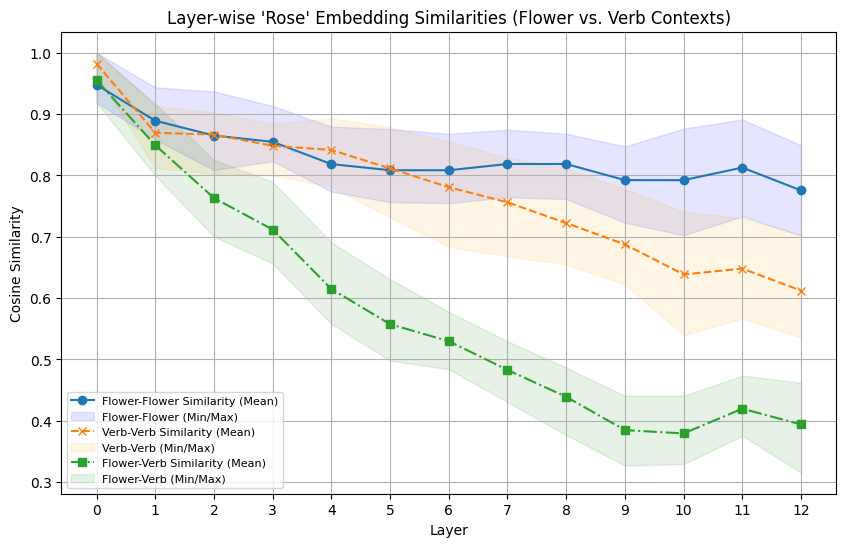

In [ ]:
num_layers = E.shape[1]
print(num_layers)
flower_indices = [i for i, label in enumerate(sense_labels) if label == "flower"]
verb_indices = [i for i, label in enumerate(sense_labels) if label == "verb"]

flower_flower_sims_mean = []
flower_flower_sims_min = []
flower_flower_sims_max = []

verb_verb_sims_mean = []
verb_verb_sims_min = []
verb_verb_sims_max = []

flower_verb_sims_mean = []
flower_verb_sims_min = []
flower_verb_sims_max = []

for layer in range(num_layers):
    current_layer_sim_matrix = layerwise_similarities[layer]

    ff_layer_sims = []
    for i in flower_indices:
        for j in flower_indices:
            if i != j:
                ff_layer_sims.append(current_layer_sim_matrix[i, j])
    flower_flower_sims_mean.append(np.mean(ff_layer_sims) if ff_layer_sims else 0)
    flower_flower_sims_min.append(np.min(ff_layer_sims) if ff_layer_sims else 0)
    flower_flower_sims_max.append(np.max(ff_layer_sims) if ff_layer_sims else 0)

    vv_layer_sims = []
    for i in verb_indices:
        for j in verb_indices:
            if i != j:
                vv_layer_sims.append(current_layer_sim_matrix[i, j])
    verb_verb_sims_mean.append(np.mean(vv_layer_sims) if vv_layer_sims else 0)
    verb_verb_sims_min.append(np.min(vv_layer_sims) if vv_layer_sims else 0)
    verb_verb_sims_max.append(np.max(vv_layer_sims) if vv_layer_sims else 0)

    fv_layer_sims = []
    for i in flower_indices:
        for j in verb_indices:
            fv_layer_sims.append(current_layer_sim_matrix[i, j])
    flower_verb_sims_mean.append(np.mean(fv_layer_sims) if fv_layer_sims else 0)
    flower_verb_sims_min.append(np.min(fv_layer_sims) if fv_layer_sims else 0)
    flower_verb_sims_max.append(np.max(fv_layer_sims) if fv_layer_sims else 0)
print(flower_flower_sims_max)
print(flower_flower_sims_mean)
print(flower_flower_sims_min)
plt.figure(figsize=(10, 6))
plt.plot(flower_flower_sims_mean, label='Flower-Flower Similarity (Mean)', marker='o', linestyle='-')
plt.fill_between(range(num_layers), flower_flower_sims_min, flower_flower_sims_max, color='blue', alpha=0.1, label='Flower-Flower (Min/Max)')

plt.plot(verb_verb_sims_mean, label='Verb-Verb Similarity (Mean)', marker='x', linestyle='--')
plt.fill_between(range(num_layers), verb_verb_sims_min, verb_verb_sims_max, color='orange', alpha=0.1, label='Verb-Verb (Min/Max)')

plt.plot(flower_verb_sims_mean, label='Flower-Verb Similarity (Mean)', marker='s', linestyle='-.')
plt.fill_between(range(num_layers), flower_verb_sims_min, flower_verb_sims_max, color='green', alpha=0.1, label='Flower-Verb (Min/Max)')

plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.title("Layer-wise 'Rose' Embedding Similarities (Flower vs. Verb Contexts)")
plt.legend(fontsize=8)
plt.grid(True)
plt.xticks(range(num_layers))
plt.show()

### Results — Verb-vs-Flower Analysis

- **Observation:** The plot clearly shows three distinct trajectories for cosine similarity across BERT's layers.
    - **Flower-Flower Similarity (solid blue line):** This trajectory starts high (around 0.95) and remains relatively high and stable, decreasing only slightly in deeper layers (around 0.78).
    - **Verb-Verb Similarity (dashed orange line):** Similar to flower-flower, this trajectory also starts high (around 0.98) and stays consistently high, with a slight decrease in deeper layers (around 0.61).
    - **Flower-Verb Similarity (dash-dot green line):** This trajectory starts moderately high (around 0.95), similar to the within-sense similarities, but drops significantly and consistently across layers, reaching a much lower value (around 0.39) in the deepest layers.

- **Interpretation:** These results strongly support the hypothesis and predictions.
    - **Prediction 1 & 2 (Flower-Flower & Verb-Verb Stability):** The high and stable (or slightly decreasing) similarities within the same semantic sense (flower-flower and verb-verb) indicate that BERT maintains consistent representations for 'rose' when its context consistently implies the same meaning. The slight decrease might be attributed to the model refining finer contextual nuances even within the same broad sense.
    - **Prediction 3 (Flower-Verb Divergence):** The significant and consistent divergence of the flower-verb similarity in deeper layers demonstrates that BERT actively disambiguates the meaning of 'rose' based on its context. In early layers, the embeddings are more general, leading to higher similarity even between different senses. However, as information propagates through the layers, BERT incorporates contextual cues to differentiate the specific meaning of 'rose', pushing the embeddings for different senses further apart. This confirms that BERT dynamically computes and refines word meaning to reflect context-dependent interpretations.

## Generate Final-Layer Similarity Heatmap

A similarity matrix for the 'rose' embeddings at the final layer (or average of top few layers) across all sentences.

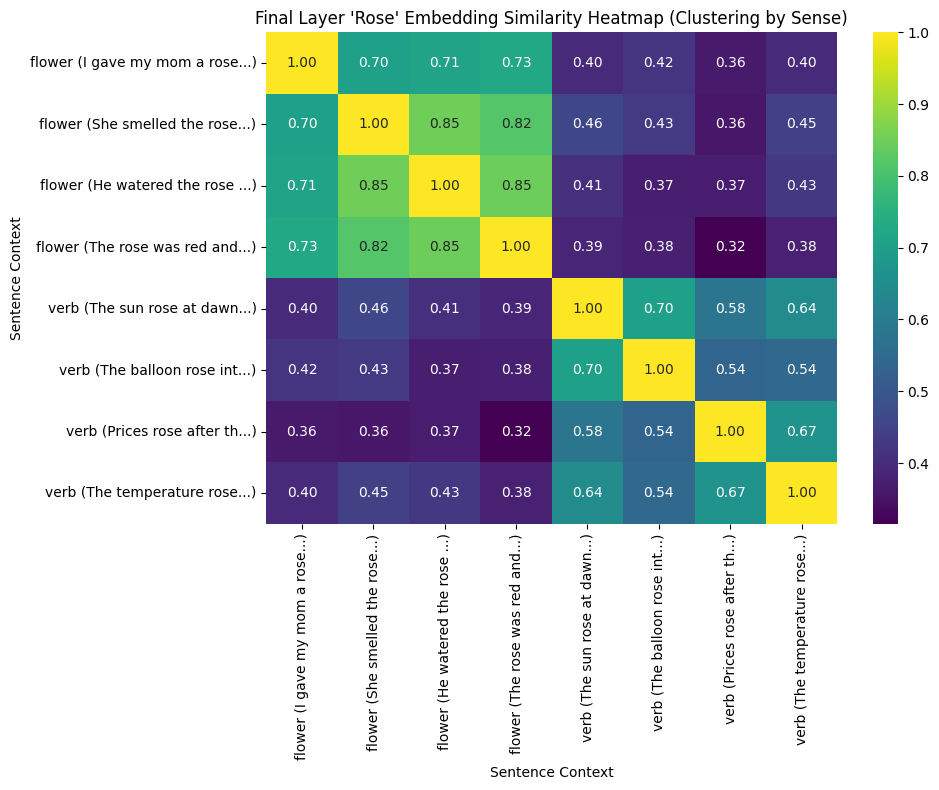

In [ ]:
final_layer_embeddings = E[:, -1, :]
final_layer_sim_matrix = np.zeros((num_sentences, num_sentences))
for i in range(num_sentences):
    for j in range(num_sentences):
        final_layer_sim_matrix[i, j] = cosine_similarity(final_layer_embeddings[i], final_layer_embeddings[j])


sentence_labels = [f"{label} ({s[:20]}...)" for label, s in zip(sense_labels, all_sentences)]
plt.figure(figsize=(10, 8))
sns.heatmap(
    final_layer_sim_matrix,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=sentence_labels,
    yticklabels=sentence_labels
)

plt.title("Final Layer 'Rose' Embedding Similarity Heatmap (Clustering by Sense)")
plt.xlabel("Sentence Context")
plt.ylabel("Sentence Context")
plt.tight_layout()
plt.show()

### Results — Final Layer Similarity Heatmap

- **Observation:** The heatmap visually confirms the findings from the layer-wise similarity plots. There are clear blocks of high similarity (darker colors, values close to 1.0) along the diagonal corresponding to within-sense comparisons:
    - The top-left 4x4 block (flower-flower comparisons) shows high similarity values.
    - The bottom-right 4x4 block (verb-verb comparisons) also shows high similarity values.
    - Conversely, the off-diagonal blocks (top-right 4x4 and bottom-left 4x4), representing flower-verb comparisons, show significantly lower similarity values (lighter colors, values closer to 0.4), indicating strong dissimilarity.

- **Interpretation:** This heatmap provides a compelling visual summary of BERT's contextual disambiguation capabilities in its final layers. It demonstrates that by the last layer, BERT has successfully differentiated the 'rose' embeddings such that those from flower contexts are highly similar to each other, and those from verb contexts are highly similar to each other. Crucially, the embeddings for 'rose' from different senses (flower vs. verb) are distinctly dissimilar. This strong clustering of embeddings by semantic sense in the final layer underscores that BERT does not merely store fixed word meanings but actively processes and refines them into distinct contextual representations.

## Generate Similarity Distribution Plots (Boxplots/Violin Plots)

boxplots or violin plots for each layer, displaying the distribution of similarity values for within-flower, within-verb, and between-sense pairs.


In [ ]:
plot_data = []

flower_indices = [i for i, label in enumerate(sense_labels) if label == "flower"]
verb_indices = [i for i, label in enumerate(sense_labels) if label == "verb"]

for layer in range(num_layers):
    current_layer_sim_matrix = layerwise_similarities[layer]
    for i in flower_indices:
        for j in flower_indices:
            if i < j:
                similarity_value = current_layer_sim_matrix[i, j]
                plot_data.append({'Layer': layer, 'Type': 'Flower-Flower', 'Similarity': similarity_value})

    for i in verb_indices:
        for j in verb_indices:
            if i < j:
                similarity_value = current_layer_sim_matrix[i, j]
                plot_data.append({'Layer': layer, 'Type': 'Verb-Verb', 'Similarity': similarity_value})

    for i in flower_indices:
        for j in verb_indices:
            similarity_value = current_layer_sim_matrix[i, j]
            plot_data.append({'Layer': layer, 'Type': 'Flower-Verb', 'Similarity': similarity_value})

df_similarities = pd.DataFrame(plot_data)

print("DataFrame for plotting created.")

DataFrame for plotting created.


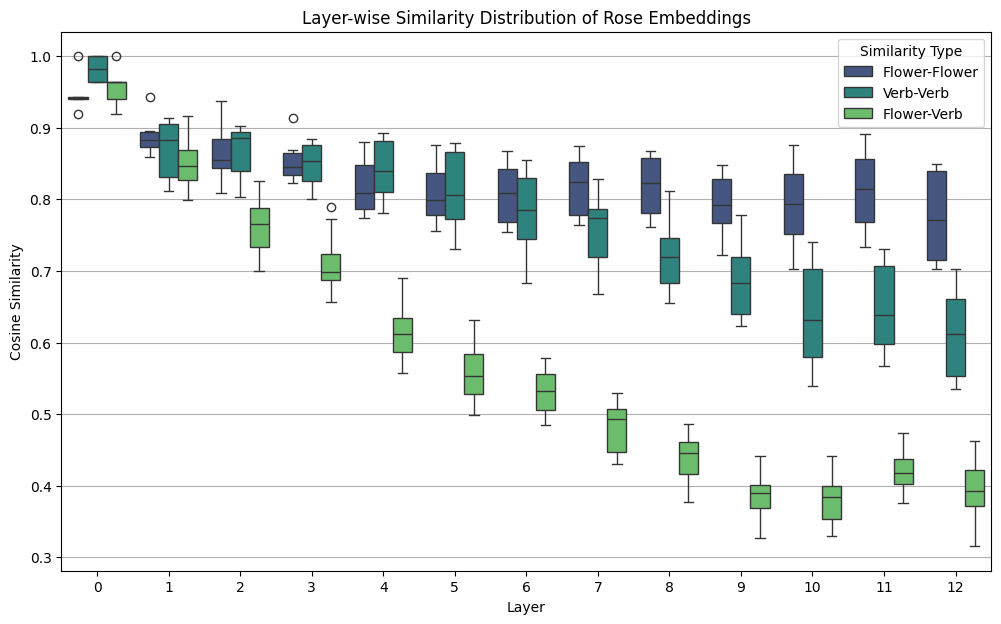

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_similarities, x='Layer', y='Similarity', hue='Type', palette='viridis')
plt.title('Layer-wise Similarity Distribution of Rose Embeddings')
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.legend(title='Similarity Type')
plt.grid(axis='y')
plt.show()


### Results — Similarity Distribution Plots (Boxplots)

- **Observation:** The boxplots reveal clear trends in the distribution of cosine similarities across layers for the 'rose' token:
    - **Flower-Flower Similarities (blue):** The median remains consistently high (above 0.8 generally) across most layers, particularly in the early layers, with a slight decrease in the deepest layers. The interquartile range (IQR, represented by the box) is relatively narrow throughout, indicating a tight clustering of similarities within the flower sense.
    - **Verb-Verb Similarities (orange):** Similar to flower-flower, the median for verb-verb similarities starts very high and remains high, though it shows a slightly more pronounced decrease than flower-flower in the deepest layers. The spread also remains relatively narrow, indicating consistent representations within the verb sense.
    - **Flower-Verb Similarities (green):** This category shows the most significant change. The median starts relatively high in early layers (similar to within-sense medians) but consistently decreases with each subsequent layer, reaching much lower values in deeper layers. Crucially, the spread (IQR and whiskers) of the flower-verb similarities tends to increase in deeper layers, indicating greater variability and less consistency in between-sense comparisons, with some outliers dropping even lower.

- **Interpretation:** These distribution plots strongly reinforce the previous findings about BERT's dynamic contextualization:
    - **Within-Sense Stability (Flower-Flower & Verb-Verb):** The consistently high medians and narrow spreads for flower-flower and verb-verb similarities confirm that BERT maintains cohesive and stable representations for 'rose' when it appears in contexts belonging to the same semantic sense. This suggests that once a sense is established, BERT's subsequent layers primarily refine and stabilize that specific meaning.
    - **Between-Sense Divergence and Disambiguation (Flower-Verb):** The progressive decrease in the median of flower-verb similarities, coupled with an increasing spread in deeper layers, is direct evidence of contextual disambiguation. In early layers, embeddings are more generic, leading to higher similarities even across different senses. As the input passes through deeper layers, BERT leverages contextual information to differentiate the 'rose' token's meaning. The widening spread suggests that while the embeddings are diverging, there might be subtle variations in how strongly 'rose' is disambiguated depending on the specific sentence pairs.

Overall, the boxplots provide a robust statistical view of how BERT gradually separates the representations of ambiguous words based on their context, validating the hypothesis that word meaning is dynamically computed rather than stored as a fixed vector.


### Conclusion

In this notebook, we investigated how BERT represents words in context by analyzing token-level embeddings across different sentences. Unlike static word embeddings, BERT produces contextualized representations, meaning that the same surface word can have different vector representations depending on its surrounding context. Our experiments comparing embeddings of the same word used in different semantic roles (e.g., noun vs. verb) demonstrate this behavior clearly, as embeddings diverge when contextual meaning changes.

To quantify contextual variation, we compared embeddings using cosine similarity, which measures directional alignment in high-dimensional space. We observed that tokens sharing semantic roles tend to have higher similarity than tokens sharing only surface form, supporting our hypothesis that BERT encodes meaning dynamically rather than storing a single representation per word type.

It is important to note that BERT operates on WordPiece tokens rather than full words. While some words correspond to a single token, others may be split into multiple subword units. In such cases, token-level embeddings must be aggregated (e.g., via averaging or selecting the first subword) to form a word-level representation. This tokenization mechanism is fundamental to how BERT represents language and should be considered when interpreting embedding similarities.

Additionally, variation in embeddings is influenced not only by semantic context but also by positional encodings and sentence-level structure. As a result, differences in embeddings should be interpreted as reflecting a combination of semantic, syntactic, and positional factors, rather than meaning alone. Furthermore, cosine similarity captures overall closeness between representations but does not identify which specific linguistic features (e.g., tense, syntactic role, or sense) are responsible for the observed differences.

Finally, our analysis focuses on embeddings extracted from a fixed pretrained BERT model. Fine-tuning on downstream tasks would likely reshape these representations, emphasizing task-relevant features while potentially reducing general semantic distinctions. Despite these limitations, the results provide clear evidence that BERT computes word meaning contextually at inference time, producing flexible representations that adapt to usage rather than relying on static word vectors.


Overall, this analysis highlights how contextual embedding models like BERT move beyond surface-level lexical representations and instead encode language as a function of both meaning and context, which is central to their success in modern NLP tasks.